# 1. Preparação do notebook

In [26]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [27]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [24]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Regime Switching] Geração de séries temporais.xlsx to [BM Regime Switching] Geração de séries temporais (1).xlsx


,regime_switching_1,regime_switching_2,regime_switching_3,regime_switching_4,regime_switching_5,regime_switching_6,regime_switching_7,regime_switching_8,regime_switching_9,regime_switching_10
0,-1.687820,-0.283843,0.126658,0.377150,-0.765880,-1.355139,0.669358,-0.694463,0.065922,-0.314608
1,-1.229467,-0.365411,-0.123630,1.177021,258.615483,297.220884,0.814437,-1.024517,0.234078,-0.685179
2,-0.830905,-0.084121,-0.025177,0.623488,-0.997694,-0.039636,0.272728,216.373252,-0.571165,-1.355646
3,0.664868,-0.326946,-0.096295,0.768356,-1.361355,-0.040746,0.740739,217.235444,-0.337167,-1.355416
4,-0.226449,0.679964,-0.601503,0.572884,-2.230610,-0.282606,0.954610,-0.636281,-0.023799,-1.782896


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [25]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [28]:
# Seleção da série
series = df['regime_switching_1'].values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [29]:
X

array([[  -1.68782018],
       [  -1.2294669 ],
       [  -0.83090496],
       ...,
       [-596.09753079],
       [-595.56600647],
       [-595.5974935 ]])

In [30]:
y

array([  -1.2294669 ,   -0.83090496,    0.66486797, ..., -595.56600647,
       -595.5974935 , -594.13785985])

## 3.2. Normalização

In [31]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [32]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [33]:
# Definição do modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))  # Ajuste para entrada correta
        out = self.fc(out[:, -1, :])
        return out

# Função para treinar LSTM com otimização de hiperparâmetros
def train_lstm(X_train, y_train, input_size):
    best_model = None
    best_loss = float('inf')
    param_grid = {
        'hidden_size': [10, 50, 100],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.001, 0.01]
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for hidden_size in param_grid['hidden_size']:
        for num_layers in param_grid['num_layers']:
            for lr in param_grid['learning_rate']:
                model = LSTMModel(input_size, hidden_size, num_layers).to(device)
                criterion = nn.SmoothL1Loss(beta=1.0)
                optimizer = optim.Adam(model.parameters(), lr=lr)

                X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
                y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

                for epoch in range(100):
                    model.train()
                    optimizer.zero_grad()
                    outputs = model(X_train_tensor)
                    loss = criterion(outputs, y_train_tensor)
                    loss.backward()
                    optimizer.step()

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    best_model = model

    return best_model

In [34]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo ELM
lstm_model = train_lstm(X_train, y_train, input_size=1)

## 3.3. Avaliação do modelo

In [35]:
# Previsões no conjunto de treino
y_train_pred_scaled = lstm_model(torch.tensor(X_train, dtype=torch.float32)).detach().numpy().flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Previsões no conjunto de teste
y_test_pred_scaled = lstm_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [36]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 24.09%
sMAPE Teste: 146.73%


In [37]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 120.39
RMSE Teste: 284.94


In [38]:
# Cálculo do Huber Loss
def huber_loss(actual, predicted, delta=1.0):
    error = predicted - actual
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss_train = huber_loss(train_results['Actual'].values, train_results['Predicted'].values)
huber_loss_test = huber_loss(test_results['Actual'].values, test_results['Predicted'].values)

print(f'Huber Loss Treino: {huber_loss_train:.2f}')
print(f'Huber Loss Teste: {huber_loss_test:.2f}')

Huber Loss Treino: 29.56
Huber Loss Teste: 209.13


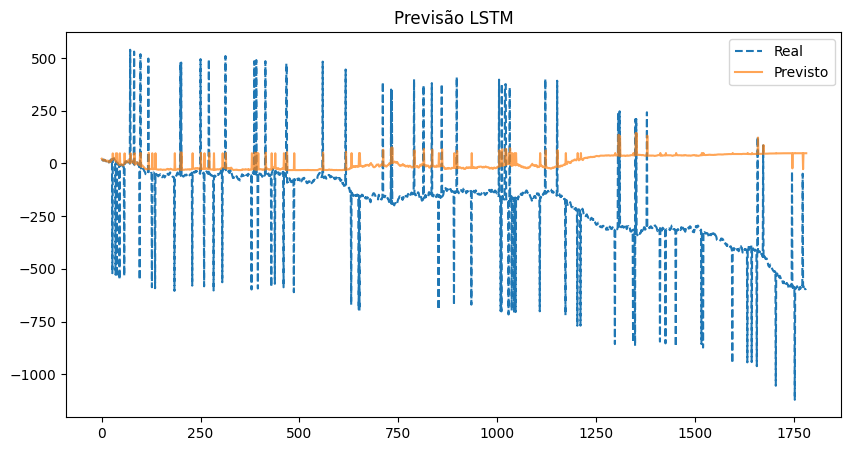

In [39]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
plt.title(f'Previsão LSTM')
plt.show()

# 4. Análise dos erros

In [40]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
39,532.645128,-5.814102,538.459230
50,530.215664,-6.065273,536.280937
73,-543.126793,-0.755987,-542.370806
80,-544.046787,-3.523909,-540.522879
170,-538.824418,3.143217,-541.967634
...,...,...,...
1778,-588.370328,48.331745,-636.702073
1779,-596.097531,48.404881,-644.502411
1780,-595.566006,48.466549,-644.032555
1781,-595.597494,48.462425,-644.059919


In [41]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,-1.229467,-0.351330,-0.878137,False
1,-0.830905,0.025860,-0.856765,False
2,0.664868,0.355373,0.309495,False
3,-0.226449,1.604561,-1.831010,False
4,-1.034204,0.857813,-1.892017,False


In [42]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 776270.0
Valor-p: 1.0
Não há evidência suficiente para afirmar que os outliers causam maiores erros.


In [43]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 2159.96743537761
Valor-p: 0.0
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [44]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: -0.3827897292039548
Valor-p: 1.1583331800064333e-206
Existe uma relação significativa entre outliers e a magnitude do erro.
